In [30]:
# Model definition
import os
import numpy as np
import pandas as pd

# SKLEARN
from sklearn.preprocessing  import ( StandardScaler, )
from sklearn.model_selection import ( train_test_split,KFold,cross_val_score, )

#KERAS 
from keras import backend
from keras import models
from keras import layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

from keras.layers import (Dense,Flatten,Embedding, SimpleRNN, LSTM, GRU, )
from keras.models import (load_model,Sequential, )
from keras.applications import (VGG16,)
from keras.preprocessing.image import (ImageDataGenerator,image,)
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.datasets import (boston_housing,mnist, imdb,)
from keras.utils import to_categorical


import matplotlib.pyplot as plt
%matplotlib inline

#from utils import plot_history

In [2]:
imdb_dir = r'G:\STUDY\Chollet - Deep LEarning With Python - Keras\aclImdb\test'
EMBED_DIM = 300
GLOVE_FILE = r'G:\KAGGLE\Quora\embeddings\glove.840B.300d\glove.840B.300d.txt'
WORD2VEC_FILE = r'G:\KAGGLE\Quora\embeddings\glove.840B.300d\word2vec.840B.300d.txt'

max_features = 10000
max_words = 10000
maxlen = 100
sample = 10000

In [3]:
(x_train, y_train),(x_test, y_test)= imdb.load_data(num_words = max_features)

print("Original shapes:", x_train.shape,x_test.shape)

if sample > 0:
    x_train  = x_train[0:sample]
    y_train  = y_train[0:sample]

x_train = pad_sequences(x_train, maxlen = maxlen)
x_test = pad_sequences(x_test, maxlen = maxlen)

print("New shapes:", x_train.shape,x_test.shape)

Original shapes: (25000,) (25000,)
New shapes: (10000, 100) (25000, 100)


In [4]:
def build_model():
    model = Sequential()
    model.add(Embedding(input_dim =max_features, output_dim = EMBED_DIM, input_length = maxlen))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['acc'])

    print(model.summary())

    return model


In [48]:
model = build_model()
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs =10, batch_size = 100, validation_split= 0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 300)          3000000   
_________________________________________________________________
flatten_16 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                960032    
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 3,960,065
Trainable params: 3,960,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 5s 564us/step - loss: 0.5653 - acc: 0.6935 - val_loss: 0.4048 - val_acc: 0.8155
Epoch 2/10
8000/8000 [==============================] - 4s 526us/step - los

KeyboardInterrupt: 

# USING RAW IMDB AND GLOVE EMBEDDINGS

In [9]:
texts = []
labels = []

for label in ['neg','pos']:
    dir_name = os.path.join(imdb_dir, label)
    for fname in os.listdir(dir_name):
        fname = os.path.join(dir_name,fname)
        if fname[-4:] == ".txt":
            with open( fname, "r", encoding="utf-8") as file:
                texts.append(file.read())
                labels.append(1 if label=='pos' else 0)

                

In [10]:
print(len(texts), len(labels))

17243 17243


In [11]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(labels)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

print (data.shape, labels.shape)

x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.2)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)


(17243, 100) (17243,)
(13794, 100) (13794,) (3449, 100) (3449,)


In [12]:
y_train[1]

0

In [13]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

glove_file = datapath(GLOVE_FILE)
tmp_file = get_tmpfile(WORD2VEC_FILE)

from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_file, tmp_file)

embed_index = KeyedVectors.load_word2vec_format(tmp_file)

C:\ProgramData\Anaconda3\envs\kaggle_py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [14]:
embed_matrix = np.zeros((max_features, EMBED_DIM))
for word, i in word_index.items():
    if i < max_features:
        if word in embed_index:
            embed_vector = embed_index[word]
            embed_matrix[i]= embed_vector
        else:
            pass
           # print("missing ", word)

In [15]:
backend.clear_session()

model = build_model()
print(embed_matrix.shape)
model.layers[0].set_weights([embed_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['acc'])

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
epochs = 5
history = model.fit(x_train, y_train, epochs =epochs, batch_size = 32,validation_data = (x_valid, y_valid))
model.save_weights("pre_rrained_glove_model.h5")

del model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,960,065
Trainable params: 3,960,065
Non-trainable params: 0
_________________________________________________________________
None
(10000, 300)
(13794, 100) (13794,) (3449, 100) (3449,)
Train on 13794 samples, validate on 3449 samples
Epoch 1/5
13794/13794 [==============================] - 6s 468us/step - loss: 0.5018 - acc: 0.7702 - val_loss: 0.5020 - val_acc: 0.7649
Epoch 2/5
13794/13

In [31]:
def plot_history(history, acc= True, loss=True):
    epochs = len(history.history["acc"])
    if acc:
        plt.Figure()
        plt.plot(range(0,epochs),history.history["acc"], label = "train acc")
        plt.plot(range(0,epochs),history.history["val_acc"],label = "valid  acc")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("accuracy")

    if loss:
        plt.figure()
        plt.plot(range(0,epochs),history.history["loss"], label = "train loss")
        plt.plot(range(0,epochs),history.history["val_loss"],label = "valid  loss")
        #plt.plot(epochs,history.history["mae"],label = "mae")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("loss")
   
#epochs = 5
#plot_history(history)

# IMDB with RNN

In [22]:
def build_rnn_model(typ="RNN"):
    model = Sequential()
    model.add(Embedding(max_features, 32))
    if typ == "LSTM":
        model.add(LSTM(32))
    elif typ == "GRU":
        model.add(GRU(32))
    else:
        model.add(SimpleRNN(32))
    model.add(Dense(1,activation = 'sigmoid' ))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    return model


In [23]:
epochs = 5

model0 = build_rnn_model("RNN")
history0 = model0.fit(x_train, y_train, epochs = epochs, batch_size=32, validation_split=0.2)

model1 = build_rnn_model("LSTM")
history1 = model1.fit(x_train, y_train, epochs = epochs, batch_size=32, validation_split=0.2)

model2 = build_rnn_model("GRU")
history2 = model2.fit(x_train, y_train, epochs = epochs, batch_size=32, validation_split=0.2)



Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - 3s 378us/step - loss: 0.6265 - acc: 0.6359 - val_loss: 0.4525 - val_acc: 0.8120
Epoch 2/5
8000/8000 [==============================] - 3s 316us/step - loss: 0.3794 - acc: 0.8385 - val_loss: 0.4209 - val_acc: 0.8175
Epoch 3/5
8000/8000 [==============================] - 3s 320us/step - loss: 0.2594 - acc: 0.8985 - val_loss: 0.4207 - val_acc: 0.8235
Epoch 4/5
8000/8000 [==============================] - 3s 317us/step - loss: 0.1660 - acc: 0.9396 - val_loss: 0.4843 - val_acc: 0.8035
Epoch 5/5
8000/8000 [==============================] - 3s 323us/step - loss: 0.0926 - acc: 0.9683 - val_loss: 0.5561 - val_acc: 0.7930
Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - 8s 1ms/step - loss: 0.5309 - acc: 0.7326 - val_loss: 0.3908 - val_acc: 0.8220
Epoch 2/5
8000/8000 [==============================] - 7s 919us/step - loss: 0.3157 - acc: 0.871

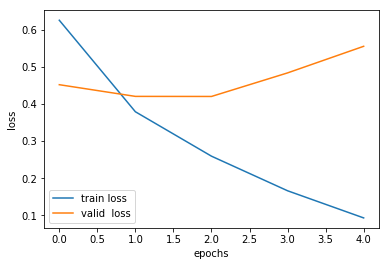

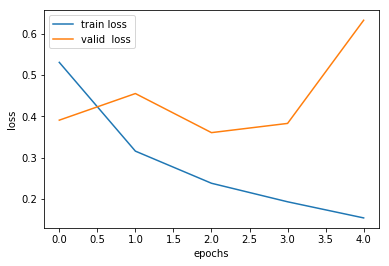

In [32]:

plot_history(history0, acc=False)
plot_history(history1, acc=False)
#plt.figure()
#plot_history(history2)

LSTM loss is less than RNN loss on valid data after 4 epochs